In [27]:
import pandas as pd
import numpy as np

from pathlib import Path


In [22]:
BASE = Path("../data")

ticker = "MS"
date = '2025-03-03'

quotes_fp_gs = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
q = pd.read_parquet(quotes_fp_gs)
q.head()

,ts,bid_price,ask_price,bid_size,ask_size,mid,spread,imbalance_l1,microprice,microprice_dev,symbol
0,2025-03-03 09:30:00-05:00,133.0,133.66,200.0,200.0,133.330,0.66,0.000000,133.33,2.842171e-14,MS
1,2025-03-03 09:30:01-05:00,133.0,133.66,200.0,200.0,133.330,0.66,0.000000,133.33,2.842171e-14,MS
2,2025-03-03 09:30:02-05:00,133.0,133.66,200.0,200.0,133.330,0.66,0.000000,133.33,2.842171e-14,MS
3,2025-03-03 09:30:03-05:00,133.0,133.39,200.0,100.0,133.195,0.39,0.333333,133.26,6.500000e-02,MS
4,2025-03-03 09:30:04-05:00,133.0,133.39,100.0,200.0,133.195,0.39,-0.333333,133.13,-6.500000e-02,MS


## Merge data

In [ ]:
BASE = Path("../data")

ticker = "SPY"
date = '2025-06-27'

quotes_fp_gs = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
prices_fp_gs = BASE / "prices" / f"{ticker}_1s_{date}.parquet"
trades_fp_gs = BASE / "trades" / f"{ticker}_trades_1s_{date}.parquet"

In [12]:
q = pd.read_parquet(quotes_fp_gs)
q.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/quotes/SPY_quotes_1s_2025-06-30.parquet'

In [9]:
q = pd.read_parquet(quotes_fp_gs).set_index('ts').add_prefix("q_")
q.shape


(23399, 9)

In [10]:
q.head()

,q_bid_price,q_ask_price,q_bid_size,q_ask_size,q_mid,q_spread,q_imbalance_l1,q_microprice,q_microprice_dev
ts,,,,,,,,,
2025-06-10 09:30:01-04:00,130.66,132.60,400.0,600.0,131.630,1.94,-0.2,131.436,-0.194
2025-06-10 09:30:02-04:00,131.39,132.60,400.0,600.0,131.995,1.21,-0.2,131.874,-0.121
2025-06-10 09:30:03-04:00,131.39,132.55,400.0,400.0,131.970,1.16,0.0,131.970,0.000
2025-06-10 09:30:04-04:00,131.39,132.46,200.0,200.0,131.925,1.07,0.0,131.925,0.000
2025-06-10 09:30:05-04:00,131.39,132.36,200.0,200.0,131.875,0.97,0.0,131.875,0.000


In [11]:
q.columns

Index(['q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size', 'q_mid',
       'q_spread', 'q_imbalance_l1', 'q_microprice', 'q_microprice_dev'],
      dtype='object')

In [16]:
t = pd.read_parquet(trades_fp).set_index('ts').add_prefix("t_")
t.shape

(23400, 5)

In [20]:
t.head()

,t_last,t_volume,t_n_trades,t_vwap,t_symbol
ts,,,,,
2025-05-02 09:30:00-04:00,562.9800,100,1,562.980000,GS
2025-05-02 09:30:01-04:00,560.0030,47359,92,561.606982,GS
2025-05-02 09:30:02-04:00,562.2175,680,25,561.811587,GS
2025-05-02 09:30:03-04:00,561.5800,402,57,561.183806,GS
2025-05-02 09:30:04-04:00,561.1400,24,21,561.497500,GS


In [18]:
t.columns

Index(['t_last', 't_volume', 't_n_trades', 't_vwap', 't_symbol'], dtype='object')

In [7]:
t.columns

Index(['t_last', 't_volume', 't_n_trades', 't_vwap', 't_symbol'], dtype='object')

In [31]:
def build_panel_1s(quotes_fp: Path, prices_fp: Path, trades_fp: Path) -> pd.DataFrame:
    q = pd.read_parquet(quotes_fp).set_index('ts').add_prefix("q_")
    p = pd.read_parquet(prices_fp).set_index('ts').add_prefix("p_")
    t = pd.read_parquet(trades_fp).set_index('ts').add_prefix("t_")

    # Inner join = only timestamps where all three exist
    panel = q.join(p, how="inner").join(t, how="inner")

    quote_cols = [c for c in panel.columns if c.startswith("q_")]
    panel[quote_cols] = panel[quote_cols].ffill()

    # Drop any rows that still have missing core state
    panel = panel.dropna(subset=["q_mid", "q_spread"])

    return panel


In [ ]:


panel = build_panel_1s(quotes_fp, prices_fp, trades_fp)
print(panel.shape)
print(panel.columns)
print(panel.head())


(23400, 22)
Index(['q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size', 'q_mid',
       'q_spread', 'q_imbalance_l1', 'q_microprice', 'q_microprice_dev',
       'p_symbol', 'p_open', 'p_high', 'p_low', 'p_close', 'p_volume',
       'p_vwap', 'p_n_trades', 't_last', 't_volume', 't_n_trades', 't_vwap',
       't_symbol'],
      dtype='object')
                           q_bid_price  q_ask_price  q_bid_size  q_ask_size  \
ts                                                                            
2025-05-02 09:30:00-04:00       567.65       567.72       100.0       100.0   
2025-05-02 09:30:01-04:00       567.29       567.36       300.0       100.0   
2025-05-02 09:30:02-04:00       567.14       567.21       300.0       100.0   
2025-05-02 09:30:03-04:00       567.12       567.18       500.0       100.0   
2025-05-02 09:30:04-04:00       567.04       567.12       500.0       100.0   

                             q_mid  q_spread  q_imbalance_l1  q_microprice  \
ts                 

## Feature Engineering

In [47]:
panel.columns

Index(['q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size', 'q_mid',
       'q_spread', 'q_imbalance_l1', 'q_microprice', 'q_microprice_dev',
       'p_symbol', 'p_open', 'p_high', 'p_low', 'p_close', 'p_volume',
       'p_vwap', 'p_n_trades', 't_last', 't_volume', 't_n_trades', 't_vwap',
       't_symbol'],
      dtype='object')

In [54]:
# z-score regime window size
w = 300 # 5min

# add targets
panel['y_ret_5s'] = np.log(panel['q_mid']).shift(-5) - np.log(panel['q_mid'])
panel['y_ret_30s'] = np.log(panel['q_mid']).shift(-30) - np.log(panel['q_mid'])

# add features
panel['x_spread_bps'] = 1e4 * panel['q_spread'] / panel['q_mid']
panel['x_imb_l1'] = panel['q_imbalance_l1']
panel['x_mp_dev'] = panel['q_microprice_dev']

# trade intensity + volume shocks
panel["x_ntrades"] = panel["t_n_trades"]
panel["x_volume"] = panel["t_volume"]

panel['x_ntrades_z'] = (panel['x_ntrades'] - panel['x_ntrades'].rolling(w).mean()) / panel['x_ntrades'].rolling(w).std()
panel['x_volume_z'] = (panel['x_volume'] - panel['x_volume'].rolling(w).mean()) / panel['x_volume'].rolling(w).std()

# vwap pressure
panel["x_vwap_mid_bps"] = 1e4 * (panel["t_vwap"] - panel["q_mid"]) / panel["q_mid"]

# short-horizon vol regime
panel["x_ret_1s"] = np.log(panel["q_mid"]).diff()
panel["x_realized_vol_30s"] = panel["x_ret_1s"].rolling(30).std()

# quote update
panel["x_quote_update"] = (
    (panel["q_bid_price"].diff() != 0) | (panel["q_ask_price"].diff() != 0)
).astype(int)
panel["x_quote_update_30s"] = panel["x_quote_update"].rolling(30).mean()

feat_cols = [c for c in panel.columns if c.startswith("x_")]
target_cols = ["y_ret_5s", "y_ret_30s"]

df = panel.dropna(subset=feat_cols + target_cols).copy()



In [55]:
panel

,q_bid_price,q_ask_price,q_bid_size,q_ask_size,q_mid,q_spread,q_imbalance_l1,q_microprice,q_microprice_dev,p_symbol,...,x_mp_dev,x_ntrades,x_volume,x_ntrades_z,x_volume_z,x_vwap_mid_bps,x_ret_1s,x_realized_vol_30s,x_quote_update,x_quote_update_30s
ts,,,,,,,,,,,,,,,,,,,,,
2025-05-02 09:30:00-04:00,567.65,567.72,100.0,100.0,567.685,0.07,0.000000,567.685000,0.000000,IVV,...,0.000000,1385,78813,NaN,NaN,-4.248911,NaN,NaN,1,NaN
2025-05-02 09:30:01-04:00,567.29,567.36,300.0,100.0,567.325,0.07,0.500000,567.342500,0.017500,IVV,...,0.017500,257,2063,NaN,NaN,2.760914,-0.000634,NaN,1,NaN
2025-05-02 09:30:02-04:00,567.14,567.21,300.0,100.0,567.175,0.07,0.500000,567.192500,0.017500,IVV,...,0.017500,157,2126,NaN,NaN,-0.119189,-0.000264,NaN,1,NaN
2025-05-02 09:30:03-04:00,567.12,567.18,500.0,100.0,567.150,0.06,0.666667,567.170000,0.020000,IVV,...,0.020000,5,6,NaN,NaN,1.675042,-0.000044,NaN,1,NaN
2025-05-02 09:30:04-04:00,567.04,567.12,500.0,100.0,567.080,0.08,0.666667,567.106667,0.026667,IVV,...,0.026667,10,34,NaN,NaN,1.100218,-0.000123,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-02 15:59:55-04:00,569.52,569.58,600.0,500.0,569.550,0.06,0.090909,569.552727,0.002727,IVV,...,0.002727,15,409,1.029642,-0.051826,0.536888,-0.000105,0.000105,1,1.0
2025-05-02 15:59:56-04:00,569.47,569.53,600.0,500.0,569.500,0.06,0.090909,569.502727,0.002727,IVV,...,0.002727,8,60,0.172936,-0.470064,-0.287591,-0.000088,0.000106,1,1.0
2025-05-02 15:59:57-04:00,569.41,569.46,700.0,500.0,569.435,0.05,0.166667,569.439167,0.004167,IVV,...,0.004167,35,2900,3.389676,2.881824,1.131400,-0.000114,0.000107,1,1.0


## Predictability Test

In [56]:
feat_cols = [c for c in df.columns if c.startswith("x_")]

ic_5s = df[feat_cols].corrwith(df["y_ret_5s"], method="spearman")
ic_30s = df[feat_cols].corrwith(df["y_ret_30s"], method="spearman")


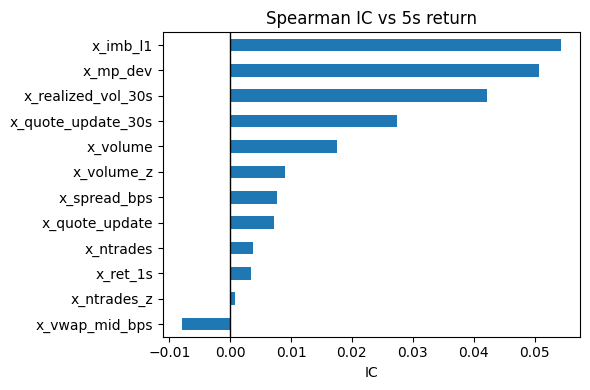

In [57]:
import matplotlib.pyplot as plt

# Spearman Information Coefficient

ic_5s.sort_values().plot(kind="barh", figsize=(6,4))
plt.axvline(0, color="black", linewidth=1)
plt.title("Spearman IC vs 5s return")
plt.xlabel("IC")
plt.tight_layout()
plt.show()


- top-of-the-book imbalance seems to be reflecting the return after 5s strongly.
- microprice deviation also reflects strong positive correlation with 5s return.

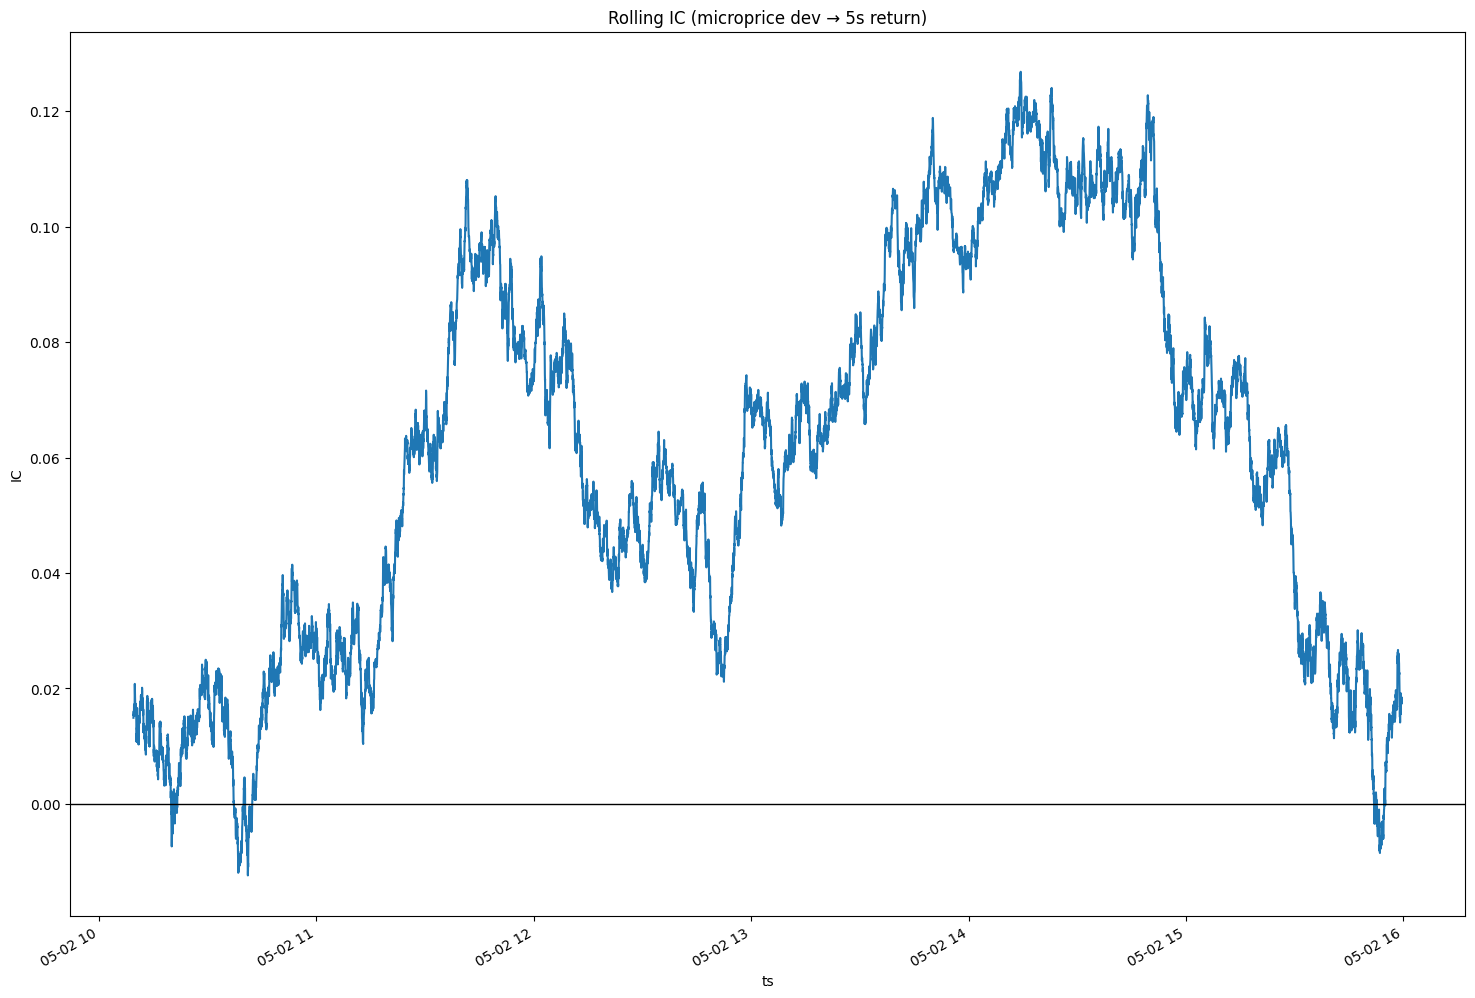

In [59]:
def rolling_ic(x, y, window):
    window = 1800  # e.g. 30 minutes at 1s

    x_rank = x.rank()
    y_rank = y.rank()

    rolling_ic = x_rank.rolling(window).corr(y_rank)
    return rolling_ic

ic_ts = rolling_ic(df["x_mp_dev"], df["y_ret_5s"], window=1800)  # 30 min

ic_ts.plot(figsize=(18,13))
plt.axhline(0, color="black", linewidth=1)
plt.title("Rolling IC (microprice dev → 5s return)")
plt.ylabel("IC")
plt.show()


## Horizon Decay

In [60]:
ics = {}

horizons = [1, 5, 10, 20, 30, 60] # seconds

for h in horizons:
    y = np.log(df['q_mid'].shift(-h)) - np.log(df['q_mid'])
    ics[h] = df['x_imb_l1'].corr(y, method='spearman')

ic_decay = pd.Series(ics)


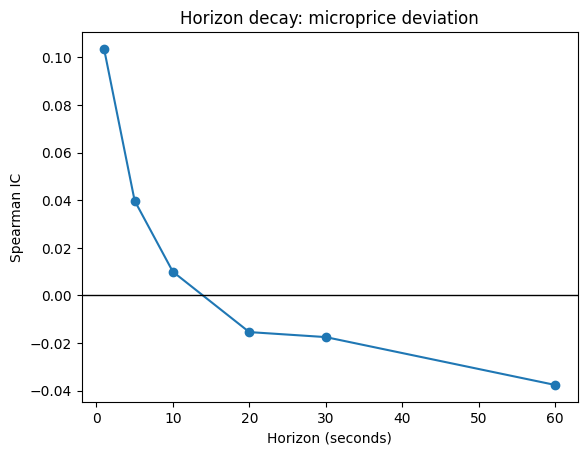

In [61]:
ic_decay.plot(marker="o")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Horizon (seconds)")
plt.ylabel("Spearman IC")
plt.title("Horizon decay: microprice deviation")
plt.show()


## Rel Val

In [32]:
BASE = Path("../data")

ticker = "MS"
date = '2025-06-02'

quotes_fp_gs = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
prices_fp_gs = BASE / "prices" / f"{ticker}_1s_{date}.parquet"
trades_fp_gs = BASE / "trades" / f"{ticker}_trades_1s_{date}.parquet"

df = build_panel_1s(quotes_fp=quotes_fp_gs, prices_fp=prices_fp_gs, trades_fp=trades_fp_gs)
df = df[['q_mid']]
df

,q_mid
ts,
2025-06-02 09:30:01-04:00,127.240
2025-06-02 09:30:02-04:00,127.240
2025-06-02 09:30:03-04:00,127.240
2025-06-02 09:30:04-04:00,127.270
2025-06-02 09:30:05-04:00,127.270
...,...
2025-06-02 15:59:55-04:00,128.395
2025-06-02 15:59:56-04:00,128.420
2025-06-02 15:59:57-04:00,128.425


In [33]:
quotes_fp_gs = BASE / "quotes" / f"SPY_quotes_1s_{date}.parquet"
prices_fp_gs = BASE / "prices" / f"SPY_1s_{date}.parquet"
trades_fp_gs = BASE / "trades" / f"SPY_trades_1s_{date}.parquet"
df_market = build_panel_1s(quotes_fp=quotes_fp_gs, prices_fp=prices_fp_gs, trades_fp=trades_fp_gs)
df_market = df_market[['q_mid']]
df_market

,q_mid
ts,
2025-06-02 09:30:00-04:00,587.915
2025-06-02 09:30:01-04:00,588.090
2025-06-02 09:30:02-04:00,588.145
2025-06-02 09:30:03-04:00,588.025
2025-06-02 09:30:04-04:00,588.055
...,...
2025-06-02 15:59:55-04:00,592.545
2025-06-02 15:59:56-04:00,592.645
2025-06-02 15:59:57-04:00,592.725


In [34]:
ts = df.index.intersection(df_market.index)
ts

DatetimeIndex(['2025-06-02 09:30:01-04:00', '2025-06-02 09:30:02-04:00',
               '2025-06-02 09:30:03-04:00', '2025-06-02 09:30:04-04:00',
               '2025-06-02 09:30:05-04:00', '2025-06-02 09:30:06-04:00',
               '2025-06-02 09:30:07-04:00', '2025-06-02 09:30:08-04:00',
               '2025-06-02 09:30:09-04:00', '2025-06-02 09:30:10-04:00',
               ...
               '2025-06-02 15:59:50-04:00', '2025-06-02 15:59:51-04:00',
               '2025-06-02 15:59:52-04:00', '2025-06-02 15:59:53-04:00',
               '2025-06-02 15:59:54-04:00', '2025-06-02 15:59:55-04:00',
               '2025-06-02 15:59:56-04:00', '2025-06-02 15:59:57-04:00',
               '2025-06-02 15:59:58-04:00', '2025-06-02 15:59:59-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='ts', length=23399, freq='s')

In [35]:
df, df_market = df.loc[ts], df_market.loc[ts]
print(df.shape, df_market.shape)

(23399, 1) (23399, 1)


In [63]:
df.rename(columns={'q_mid': 'gs_mid'}, inplace=True)
df_market.rename(columns={'q_mid': 'spy_mid'}, inplace=True)

In [74]:
df_merged = df.join(df_market, how='left')
df_merged.reset_index(inplace=True)
df_merged

,ts,gs_mid,spy_mid
0,2025-06-02 09:30:01-04:00,127.240,588.090
1,2025-06-02 09:30:02-04:00,127.240,588.145
2,2025-06-02 09:30:03-04:00,127.240,588.025
3,2025-06-02 09:30:04-04:00,127.270,588.055
4,2025-06-02 09:30:05-04:00,127.270,588.185
...,...,...,...
23394,2025-06-02 15:59:55-04:00,128.395,592.545
23395,2025-06-02 15:59:56-04:00,128.420,592.645
23396,2025-06-02 15:59:57-04:00,128.425,592.725
23397,2025-06-02 15:59:58-04:00,128.435,592.760


In [76]:
EPS = 1e-12
window = 300

def ols_alpha_beta(y, x):
    y_bar = y.mean()
    x_bar = x.mean()
    
    dx = x - x_bar
    dy = y - y_bar 

    var_x = (dx*dx).mean()
    if var_x < EPS:
        return 0.0, 0.0
    cov_xy = (dy*dx).mean()

    beta = cov_xy / (var_x + EPS)
    alpha = y_bar - beta * x_bar
    
    return alpha, beta



In [ ]:
signals = []
base_size = 50
current_qty = 0

for i in range(window+1, len(df_merged)):
    dfw = df_merged.iloc[i-(window+1):i]
    r_m = np.log(dfw["spy_mid"]).diff().dropna()
    r  = np.log(dfw["gs_mid"]).diff().dropna()

    a, b = ols_alpha_beta(r, r_m)
    
    eps = r - (a + b * r_m)
    sigma_eps = eps.std(ddof=1)
    z = float((eps.iloc[-1] - eps.mean()) / (sigma_eps + 1e-12)) if sigma_eps > 1e-12 else 0.0
    print(df_merged.loc[i]['ts'], z, a, b)

    if z > 2.0:
        signals.append((z,))
    elif z < -2.0:
        signals.append((z,))
    else:
        continue
    
    if abs(z) < 0.5:
        signals.append((z,))
    else:
        continue
    

len(signals)

2025-06-02 09:35:02-04:00 -0.06295233230815403 8.39722748758871e-06 0.12326335814609754
2025-06-02 09:35:03-04:00 -0.07720261071179867 8.418393912827312e-06 0.1242360573478686
2025-06-02 09:35:04-04:00 -0.06257603419182649 8.312117645552867e-06 0.126607453658604
2025-06-02 09:35:05-04:00 -0.05762755168683094 7.592456714994089e-06 0.1202290653611471
2025-06-02 09:35:06-04:00 -0.14224087616054285 7.6116552688794864e-06 0.12373310566819641
2025-06-02 09:35:07-04:00 0.02028883270194918 7.570663536210309e-06 0.1249899790244613
2025-06-02 09:35:08-04:00 0.034082941862815595 7.5911399220765225e-06 0.12459862887479467
2025-06-02 09:35:09-04:00 0.07545431838589854 7.689105626838993e-06 0.12417752774611793
2025-06-02 09:35:10-04:00 -2.088158961666383 6.651861545050582e-06 0.1379031188395768
2025-06-02 09:35:11-04:00 -1.3524299675729707 5.8188393709197325e-06 0.13883460228441244
2025-06-02 09:35:12-04:00 -0.14681597732034557 5.802128581758261e-06 0.1377588961864602
2025-06-02 09:35:13-04:00 -0.02

1180

In [56]:
df_merged.loc['2025-06-02 15:59:57-0400']

gs_mid     128.425
spy_mid    592.725
Name: 2025-06-02 15:59:57-04:00, dtype: float64